# Carvana Image Masking Challenge 

The goal of this challenge is to create a machine learning model capable of masking images. So that the car will be separated from the background.

The purpose of create a model to do this. Is because image masking is a very time consuming task. Itâ€™s also not very difficult to do so larger image masking jobs can potentially be outsourced. Paying high end designers to do masks among otherthings is generally a waste of time. Companies like Adobe have picked up on this and every new version of photoshop increases tools to help automate the masking process.

The plan is to create two different versions of fully convolutional networks to mask the training and test images.

[DATA](https://www.kaggle.com/c/carvana-image-masking-challenge/data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import glob
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

from torchvision import transforms, datasets
import torchvision.models as models

# Exploring Metadata
By doing so we can get a better feel for the types of cars that the model will be trained on.

In [2]:
df = pd.read_csv('data/metadata.csv')
df = df.dropna()
df.shape

(6485, 6)

# Number of Cars by Year

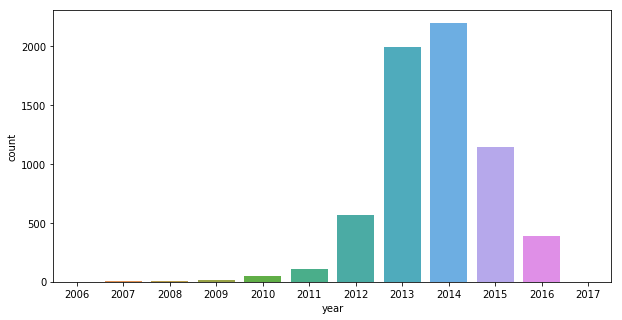

In [3]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x=df['year'].astype('int'))
plt.show()

# Number of Cars by Make

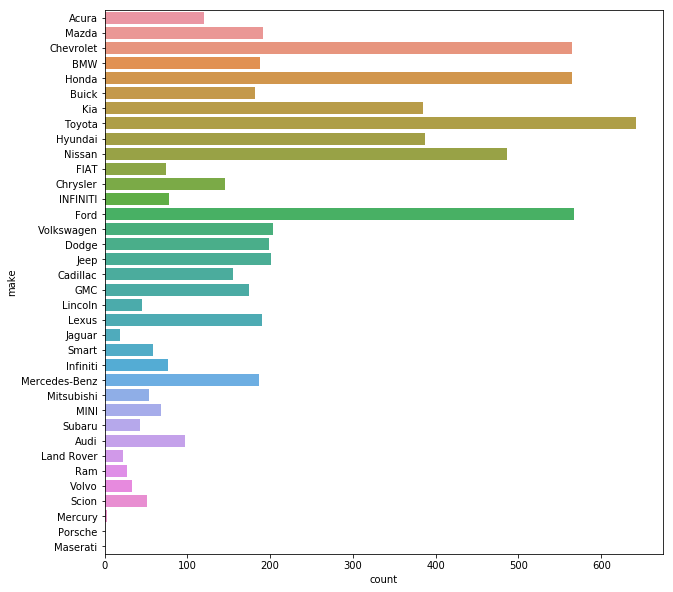

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
sns.countplot(y=df['make'], orient='h')
plt.show()

# Previewing Train Images

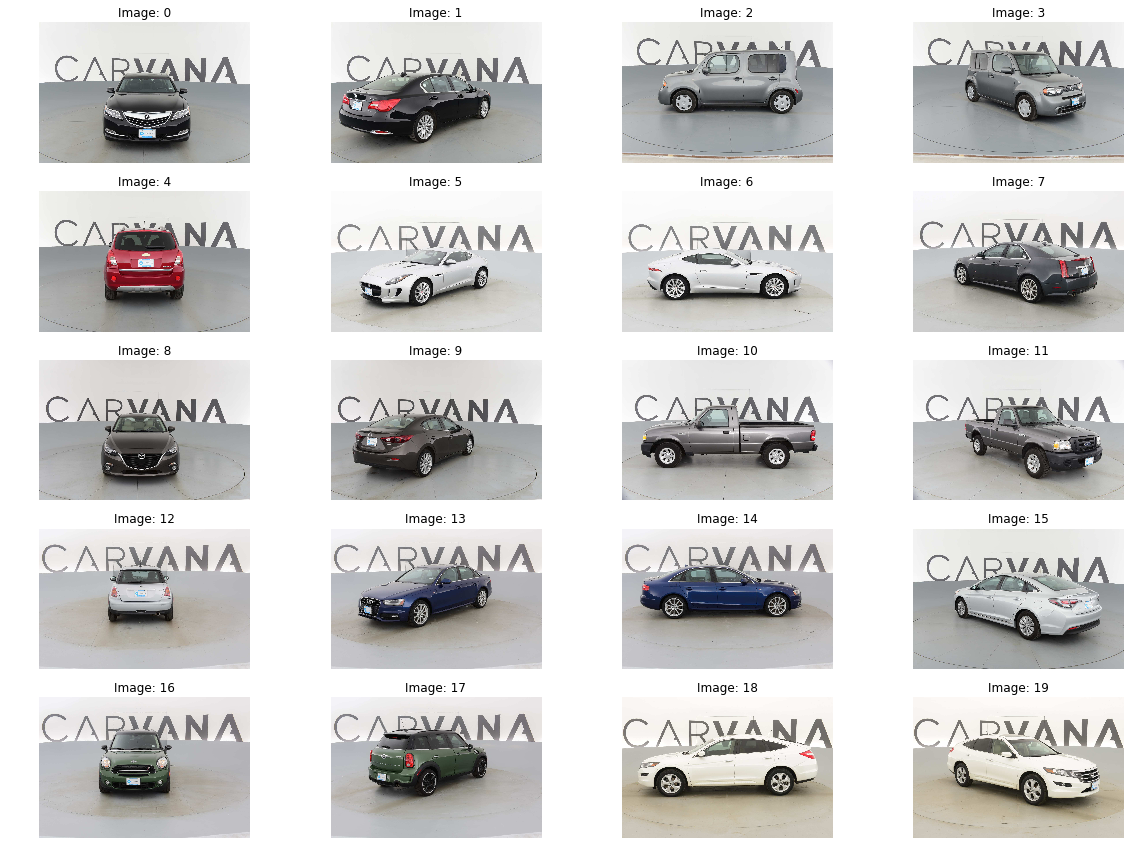

In [5]:
def get_images(folder, img_type, image_iter=None):
    fig = plt.figure(figsize=(20, 15))
    
    images = glob.glob(folder + '/*.' + img_type)
    
    if image_iter is not None:
        images = images[0::image_iter] # Selecting every 10th image to get a better variety

    counter = 0
    for image in images:
        if counter >= 20:
            break
        plt.subplot(5, 4, counter + 1)
        plt.axis('off')
        preview = Image.open(image)
        preview = np.array(preview)
        plt.imshow(preview.squeeze(), cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title(f'Image: {counter}')
        counter += 1

    plt.show()

folder = './data/train'
img_type = 'jpg'
image_iter = 10

get_images(folder, img_type, image_iter)

# Previewing Test Images

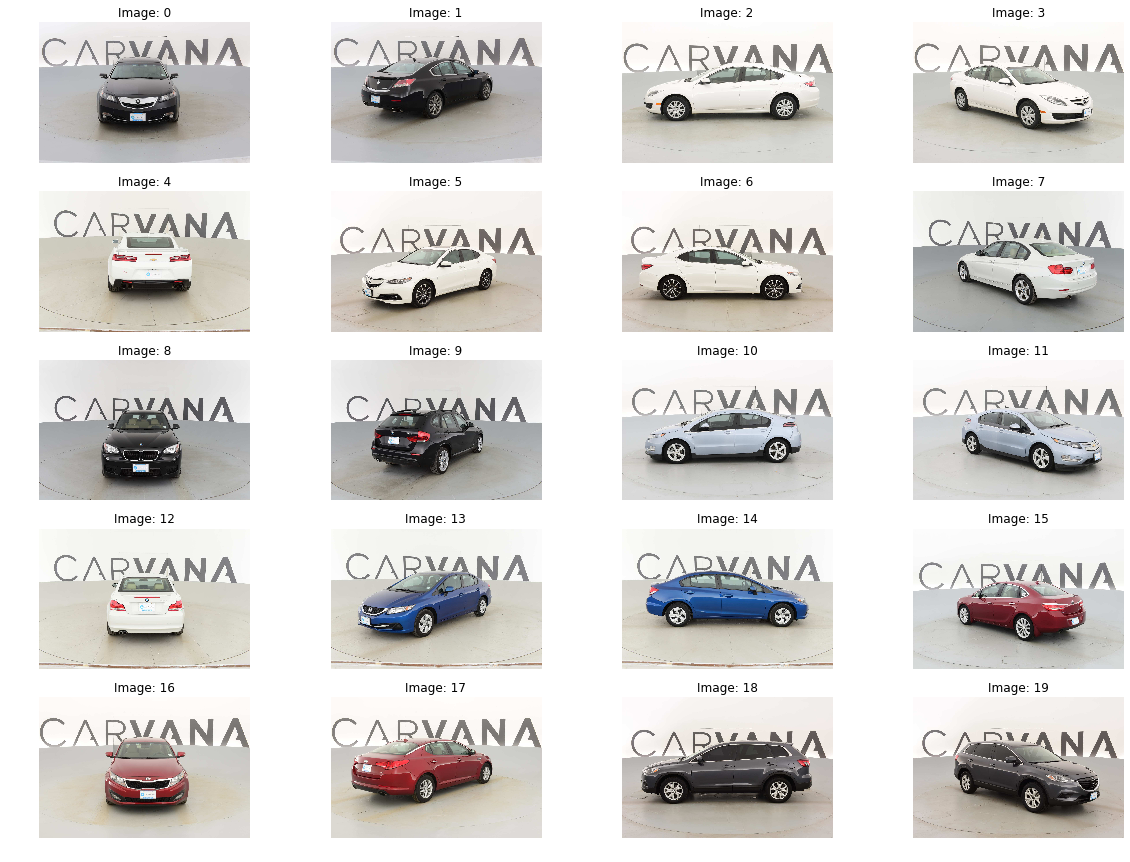

In [6]:
folder = './data/test'
img_type = 'jpg'
image_iter = 10

get_images(folder, img_type, image_iter)

# Previewing Masks 

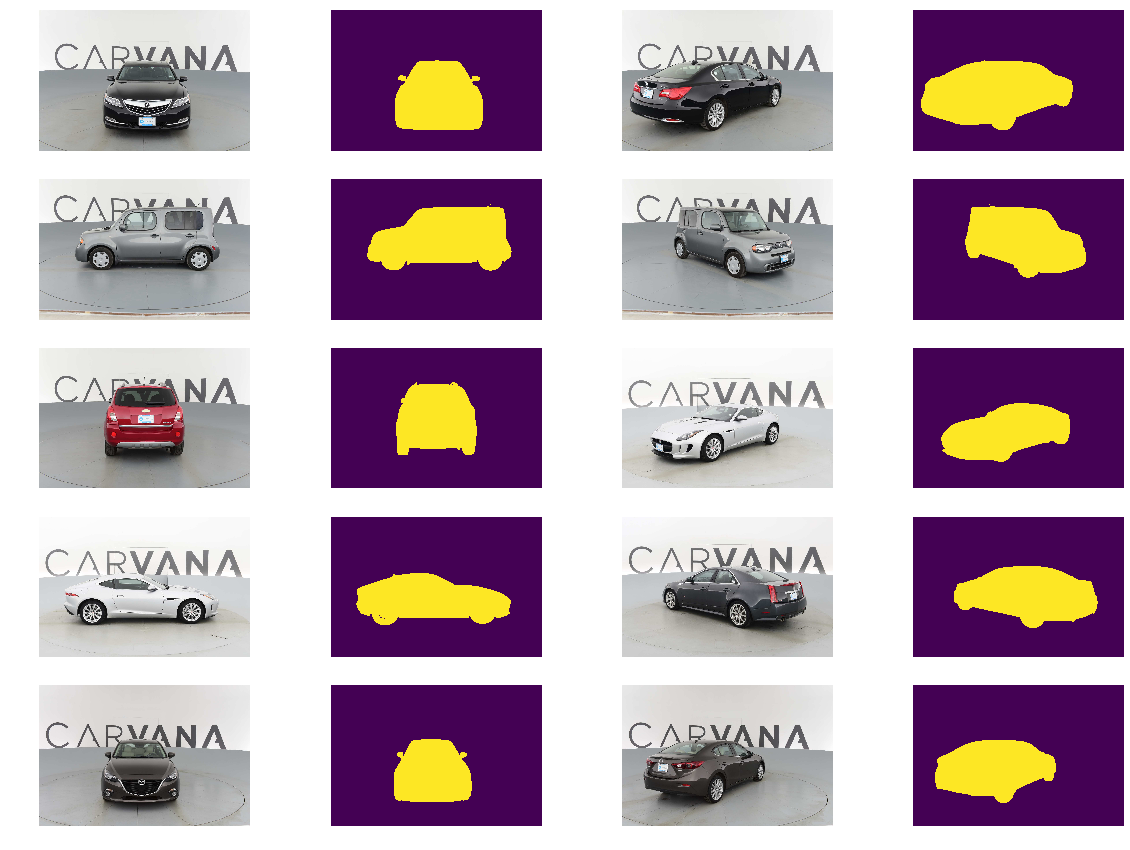

In [7]:
fig = plt.figure(figsize=(20, 15))

train = glob.glob('./data/train/*.jpg')
masks = glob.glob('./data/train_masks/*.gif' )
image_iter = 10

train = train[0::image_iter] # Selecting every 10th image to get a better variety
masks = masks[0::image_iter]

counter = 0
for image, mask in zip(train, masks):
    if counter >= 20:
        break
    plt.subplot(5, 4, counter + 1)
    plt.axis('off')
    train = Image.open(image)
    train = np.array(train)
    mask = Image.open(mask)
    mask = np.array(mask)
    plt.imshow(train.squeeze(), interpolation='nearest')
    counter +=1
    
    plt.subplot(5, 4, counter + 1)
    plt.axis('off')
    plt.imshow(mask.squeeze(), interpolation='nearest')
    counter += 1

plt.show()

# Reflections on Image Data
Overall the images and masks appear to be of high quality. This will help the model produce the most accurate masks that it can.

# Data Loading
Creating a PyTorch dataset object to handle data loading and pre-processing

In [8]:
batch_size = 1

class CarvanaDataset(Dataset):
    def __init__(self, operation='train', transform=None):
        self.operation = operation
        self.transform = transform
        
        if self.operation == 'train':
            self.imgs = glob.glob('../final/data/train/*.jpg')
            self.labels = glob.glob('../final/data/train_masks/*.gif')
            
        elif self.operation == 'test':
            self.imgs = glob.glob('../final/data/test/*.jpg')
            self.labels = glob.glob('../final/data/train_masks/*.gif')
            
    def __getitem__(self, index):
        # Load images and labels
        img = Image.open(self.imgs[index]).convert('RGB')
        target = Image.open(self.labels[index]).convert('1')
        
        # Apply transformations
        if self.transform is not None:
            img = self.transform(img)
            img /= 255.0
            target = self.transform(target)
            
        return img, target
    
    def __len__(self):
        return len(self.imgs)
    
data_transform = transforms.Compose([
        transforms.Resize([256,256]),
        transforms.ToTensor()
    ])

# Initializing train data loader
train_dataset = CarvanaDataset(transform=data_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# PyTorch Fully Convolutional Neural Network.

This architecture has been proven to be a strong contender for image segmentation tasks. By not including a fully connected linear layer the convolutional layers can focus on features within the images. The downside to fully convolutional neural networks is that they're computationally expensive. However by downsampling, max pooling and then upsampling the overall computational cost can be reduced. The following neural net architecture below closely follows the research proposed in the U-Net paper. The main idea is to use the features learned form downsampling to help rescale the image. By doing so it helps assure a crisper mask.

For an imaging task like this that doesn't require speed but accuracy U-Net is the clear winner. Other approaches like YOLO(You Only Look Once) that makes use of the fast RCNN architecture are much faster but typically produces less accurate masks. 

![U-Net](https://cdn-images-1.medium.com/max/1600/1*lvXoKMHoPJMKpKK7keZMEA.png)

Below there are three classes.
* Interpolate - Makes use of PyTorch's Interpolate that will scale images bilinearly. This class will be called to handle upscaling within the ConvNet class.
* ConvNet - U-Net Transfer Learning Model with a VGG11 encoder for downscaling.
* FCN - Follows the U-Net architecture and uses Conv2dTranspose layers instead of the interpolate class. This model will be trained from scratch with no pretrained weights.

In [9]:
class Interpolate(nn.Module):
    '''
    Layer to handle feature upscaling
    '''
    def __init__(self, scale_factor, mode, align):
        super(Interpolate, self).__init__()
        self.interp = F.interpolate
        self.scale = scale_factor
        self.mode = mode
        self.align = align
        
    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale, mode=self.mode, align_corners=self.align)
        return x

class ConvNet(nn.Module):
    def __init__(self, use_vgg=False):
        super(ConvNet, self).__init__()
        
        if use_vgg:
            self.encoder = models.vgg11(pretrained=True).features
            self.relu = self.encoder[1]
            self.maxpool = self.encoder[2]
            self.down_layer1 = nn.Sequential(
                self.encoder[0],
                self.relu,
                self.encoder[3],
                self.relu
            )
            
            self.down_layer2 = nn.Sequential(
                self.encoder[6],
                self.relu,
                self.encoder[8],
                self.relu
            )
            
            self.down_layer3 = nn.Sequential(
                self.encoder[11],
                self.relu,
                self.encoder[13],
                self.relu
            )
            
            self.down_layer4 = nn.Sequential(
                self.encoder[16],
                self.relu,
                self.encoder[18],
                self.relu
            )

            self.center = nn.Sequential(
                nn.Conv2d(512, 1024, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
                nn.ReLU(inplace=True))

            self.maxpool = nn.MaxPool2d(2)
            
        
        self.up_sample_layer = nn.Sequential(
             Interpolate(scale_factor=2, mode='bilinear', align=True),
        )    
        
        if use_vgg:
            self.up_layer1 = nn.Sequential(
                 nn.Conv2d(512, 512, kernel_size=3, padding=1),
                 nn.ReLU(inplace=True),
                 nn.Conv2d(512, 512, kernel_size=3, padding=1),
                 nn.ReLU(inplace=True))

            self.up_layer2 = nn.Sequential(
                 nn.Conv2d(1024, 256, kernel_size=3, padding=1),
                 nn.ReLU(inplace=True),
                 nn.Conv2d(256, 256, kernel_size=3, padding=1),
                 nn.ReLU(inplace=True))

            self.up_layer3 = nn.Sequential(
                 nn.Conv2d(768, 128, kernel_size=3, padding=1),
                 nn.ReLU(inplace=True),
                 nn.Conv2d(128, 128, kernel_size=3, padding=1),
                 nn.ReLU(inplace=True))
            
            self.up_layer4 = nn.Sequential(
                 nn.Conv2d(384, 64, kernel_size=3, padding=1),
                 nn.ReLU(inplace=True),
                 nn.Conv2d(64, 64, kernel_size=3, padding=1),
                 nn.ReLU(inplace=True))
            
            self.up_layer5 = nn.Sequential(
                 nn.Conv2d(192, 64, kernel_size=3, padding=1),
                 nn.ReLU(inplace=True),
                 nn.Conv2d(64, 64, kernel_size=3, padding=1),
                 nn.ReLU(inplace=True))
        
            
        self.out_layer = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        
        
    def forward(self, x):
        conv1 = self.down_layer1(x)
        x = self.maxpool(conv1)
        
        conv2 = self.down_layer2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.down_layer3(x)
        x = self.maxpool(conv3)
        
        conv4 = self.down_layer4(x)
        x = self.maxpool(conv4)
        
        center = self.center(x)
        
        x = self.up_layer1(x)
        x = self.up_sample_layer(x)
        x = torch.cat([x, conv4], dim=1)
        
        x = self.up_layer2(x)
        x = self.up_sample_layer(x)
        x = torch.cat([x, conv3], dim=1)
        
        x = self.up_layer3(x)
        x = self.up_sample_layer(x)
        x = torch.cat([x, conv2], dim=1)
        
        x = self.up_layer4(x)
        x = self.up_sample_layer(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.up_layer5(x)
        
        x = self.out_layer(x)
        
        return x
    
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()

        self.max_pool = nn.MaxPool2d(2)
        
        self.down_layer1 = nn.Sequential(
            # 1st conv block
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
            
        self.down_layer2 = nn.Sequential(
            # 2nd conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
            
        self.down_layer3 = nn.Sequential(
            # 3rd conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
            
        self.down_layer4 = nn.Sequential(
            # 4th conv block
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
            
        self.center_layer = nn.Sequential(
            # Bottleneck layer
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.up_layer4 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=2, padding=0, stride=2, output_padding=0),
            nn.ReLU(inplace=True),
        )
        self.up_conv4 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.up_layer3 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, padding=0, stride=2, output_padding=0),
            nn.ReLU(inplace=True),
        )            
        self.up_conv3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
            
        self.up_layer2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, padding=0, stride=2, output_padding=0),
            nn.ReLU(inplace=True),
        ) 
        self.up_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
            
        self.up_layer1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, padding=0, stride=2, output_padding=0),
            nn.ReLU(inplace=True),
        )
        self.up_conv1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
            
        self.out_layer = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        
        
    def forward(self, x):
        conv1 = self.down_layer1(x)
        x = self.max_pool(conv1)
        
        conv2 = self.down_layer2(x)
        x = self.max_pool(conv2)
        
        conv3 = self.down_layer3(x)
        x = self.max_pool(conv3)
        
        conv4 = self.down_layer4(x)
        x = self.max_pool(conv4)
        
        center = self.center_layer(x)
        
        up4 = self.up_layer4(center)
        lower = int((conv4.shape[2] - up4.shape[2]) / 2)
        upper = int(conv4.shape[2] - lower)
        conv_feats = conv4[:, :, lower:upper, lower:upper]
        x = torch.cat([up4, conv_feats], dim=1)
        x = self.up_conv4(x)
        
        up3 = self.up_layer3(x)
        lower = int((conv3.shape[2] - up3.shape[2]) / 2)
        upper = int(conv3.shape[2] - lower)
        conv_feats = conv3[:, :, lower:upper, lower:upper]
        x = torch.cat([up3, conv_feats], dim=1)
        x = self.up_conv3(x)
        
        up2 = self.up_layer2(x)
        lower = int((conv2.shape[2] - up2.shape[2]) / 2)
        upper = int(conv2.shape[2] - lower)
        conv_feats = conv2[:, :, lower:upper, lower:upper]
        x = torch.cat([up2, conv_feats], dim=1)
        x = self.up_conv2(x)
        
        up1 = self.up_layer1(x)
        lower = int((conv1.shape[2] - up1.shape[2]) / 2)
        upper = int(conv1.shape[2] - lower)
        conv_feats = conv1[:, :, lower:upper, lower:upper]
        x = torch.cat([up1, conv_feats], dim=1)
        x = self.up_conv1(x)
        
        x = self.out_layer(x)
        
        return x

# Utilities
The following functions are used to aid the training process of the convolutional neural network.

- The Dice loss function is not included in PyTorch, below is the code to implementing it.

- The Save model function saves variations of the model.

In [10]:
def dice_loss(preds, trues, weight=None, is_average=True):
    num = preds.size(0)
    preds = preds.view(num, -1)
    trues = trues.view(num, -1)
    if weight is not None:
        w = torch.autograd.Variable(weight).view(num, -1)
        preds = preds * w
        trues = trues * w
    intersection = (preds * trues).sum(1)
    scores = 2. * (intersection + 1) / (preds.sum(1) + trues.sum(1) + 1)

    if is_average:
        score = scores.sum()/num
        return torch.clamp(score, 0., 1.)
    else:
        return scores

def dice_clamp(preds, trues, is_average=True):
    preds = torch.round(preds)
    return dice_loss(preds, trues, is_average=is_average)

class DiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction

    def forward(self, input, target, weight=None):
        return 1-dice_loss(torch.sigmoid(input), target, weight=weight, is_average=self.reduction)

class BCEDiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction
        self.dice = DiceLoss(reduction=reduction)

    def forward(self, input, target, weight=None):
        return nn.modules.loss.BCEWithLogitsLoss(reduction=self.reduction, weight=weight)(input, target) + self.dice(input, target, weight=weight)

        
def save_model(model, epoch, name):
    '''
    Utility function for saving the model after each epoch
    '''
    out_dir = './data/models/' + str(name) + '_'+ str(epoch)
    torch.save(model.state_dict(), out_dir)

# U-Net PyTorch Model Using Transfer Learning
By using a model with pre-trained weights the training process will be accelerated. Hopefully implementing VGG11 will also increase the accuracy of the final result. I had two factors in selecting VGG11: first was computational limitations, and the second was that it scored very well amongst the smaller models.

In [11]:
load = False
model = ConvNet(use_vgg=True)

if load:
    checkpoint = torch.load('G:\\projects\\thinkful\\final\\data\\models\\dice_test_epoch_round_2_19')
    model.load_state_dict(checkpoint)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# After 10 epochs the learning rate will be reduced
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)     

# Loss Function
criterion = BCEDiceLoss().cuda()

if torch.cuda.is_available():
    model = model.cuda()

# The VGG11 Layers that were taken when creating the model
models.vgg11(pretrained=True).features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU(inplace)
  (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU(inplace)
  (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (16): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17)

In [12]:
def train(train_loader, model, epoch, num_epochs):
    '''
    This function oversees the training process
    '''
    model.train()
    scheduler.step()

    hist_loss = []
    hist_epoch = []
    # create a progress bar
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in pbar:
        # Convert torch tensor to Variable
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())

        # compute output
        optimizer.zero_grad()
        outputs = model(images)

        # measure loss
        loss = criterion(outputs, labels)

        # compute gradient and do optimizer step
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)     # Prevents the gradient from going out of control
        optimizer.step()

        pbar.set_description('[TRAIN] - EPOCH %d/ %d - BATCH LOSS: %.4f'
                             % (epoch + 1, num_epochs, loss.data))
        
    
    return loss.data

# Running The Transfer Learning Model

In [13]:
train_model = True
n_epochs = 30

if train_model:
    loss_hist = []
    for epoch in range(n_epochs):
        curr_loss = train(train_loader, model, epoch, n_epochs)
        loss_hist.append(curr_loss)
        save_model(model, epoch, 'VGG_UNET')

    loss_hist = np.array(loss_hist)
    np.savez('VGG_UNET_loss', loss_hist)
    print(f'Ending Loss - {curr_loss}')

[TRAIN] - EPOCH 30/ 30 - BATCH LOSS: 0.0060: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 5088/5088 [17:56<00:00,  4.74it/s]


Ending Loss - 0.005986505188047886


# Previewing Results - Train Data - Transfer Learning
Both models tested have been ran for 30 epochs using the Adam optimizer. Epochs 0-10 the model used the learning rate of 1e-3. Every 10 epochs the learning rate is lowered by 0.1 

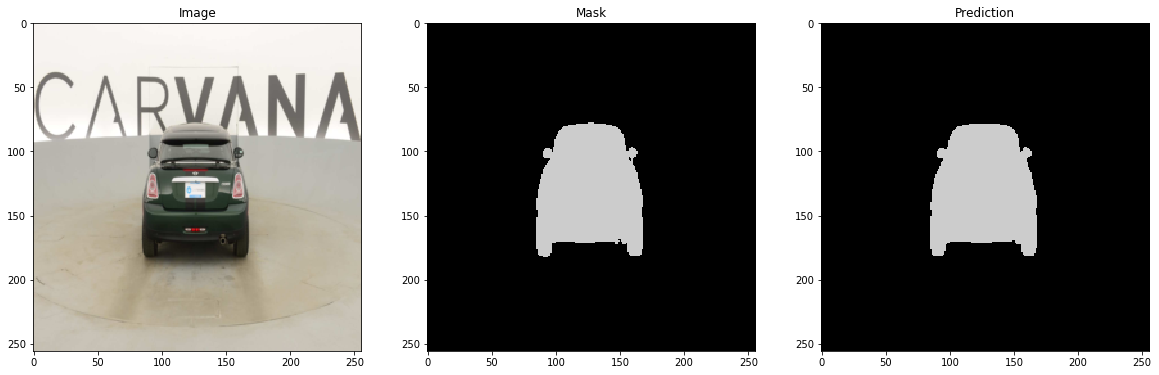

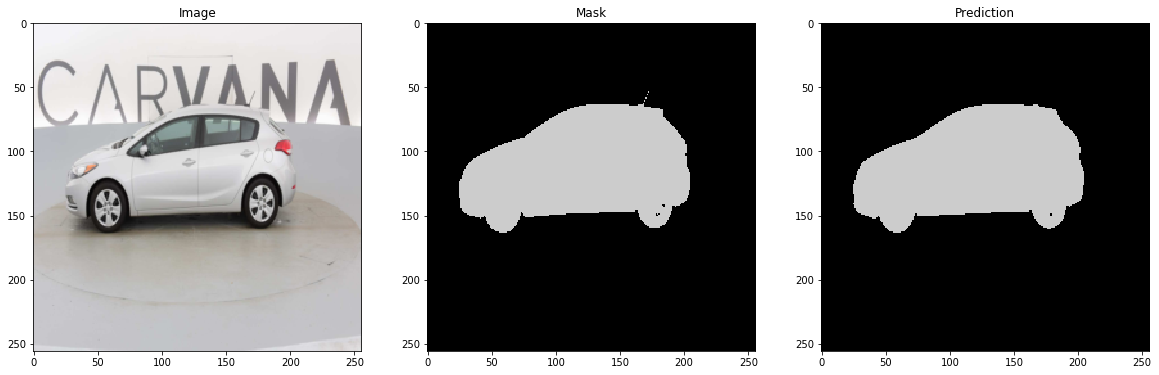

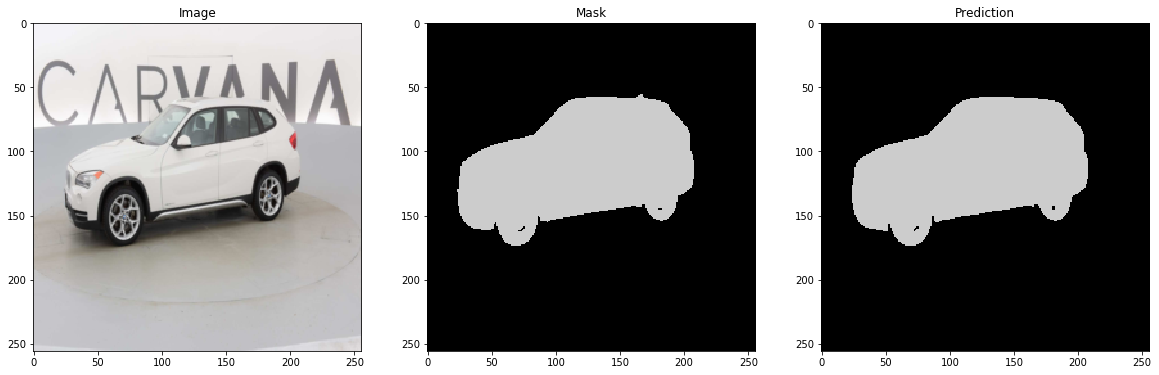

In [14]:
def model_preview():
    model.eval()
    counter = 0

    for i, (inputs, labels) in enumerate(train_loader):
        fig, axes = plt.subplots(1, 3, figsize=(20,15))
        row = counter
        inputs = inputs.cuda()
        labels = labels.cuda()

        # Predict
        pred = model(inputs)
        pred = pred.data.cpu().numpy()
        pred = pred.squeeze()

        true = torch.sigmoid(labels)
        true = true.data.cpu().numpy()
        true = true.squeeze()

        img_p = inputs.data.cpu().numpy()
        img_p = img_p.squeeze()*255
        img_p = np.moveaxis(img_p, 0, -1)

        axes[0].imshow(img_p, interpolation='nearest')
        axes[1].imshow(true, cmap='nipy_spectral', interpolation='nearest')
        axes[2].imshow(pred > 0.5, cmap='nipy_spectral', interpolation='nearest')

        axes[0].set_title('Image')
        axes[1].set_title('Mask')
        axes[2].set_title('Prediction')
        counter += 1
        if counter > 2:
            break
        plt.show()

model_preview()

# Previewing Results - Test Data - Transfer Learning

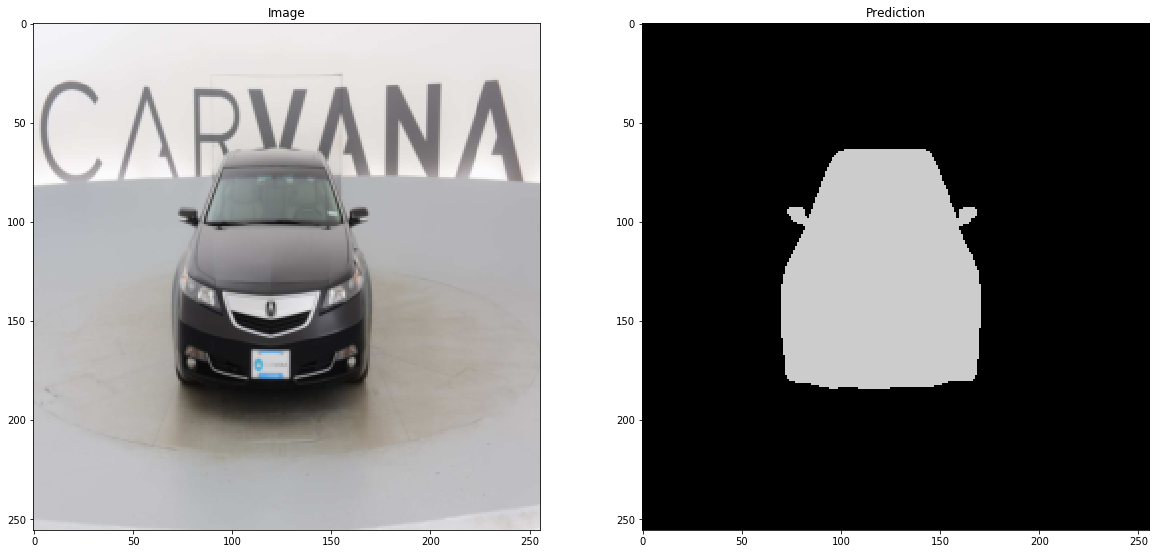

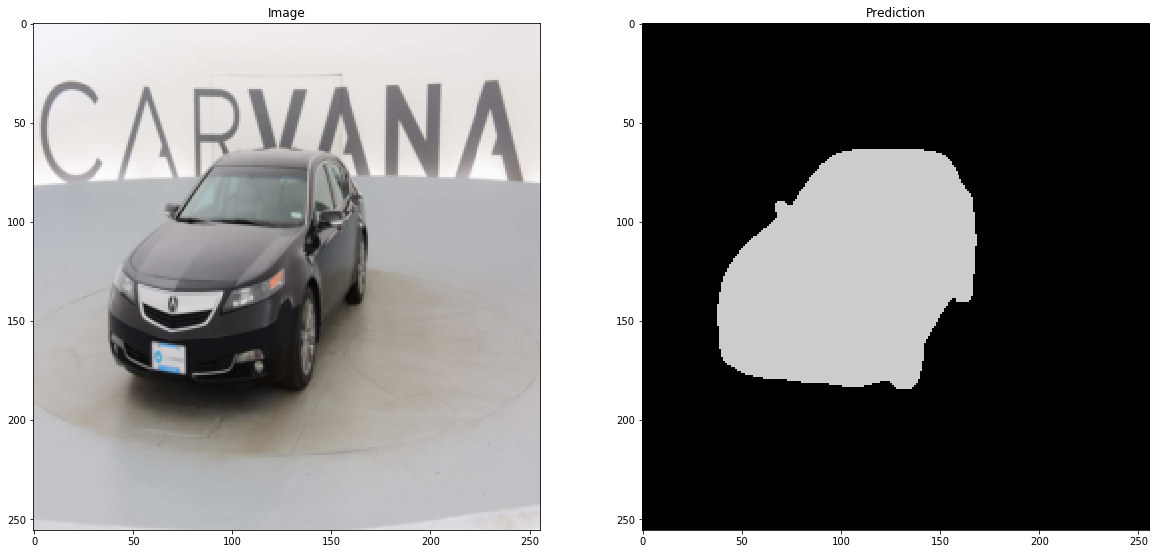

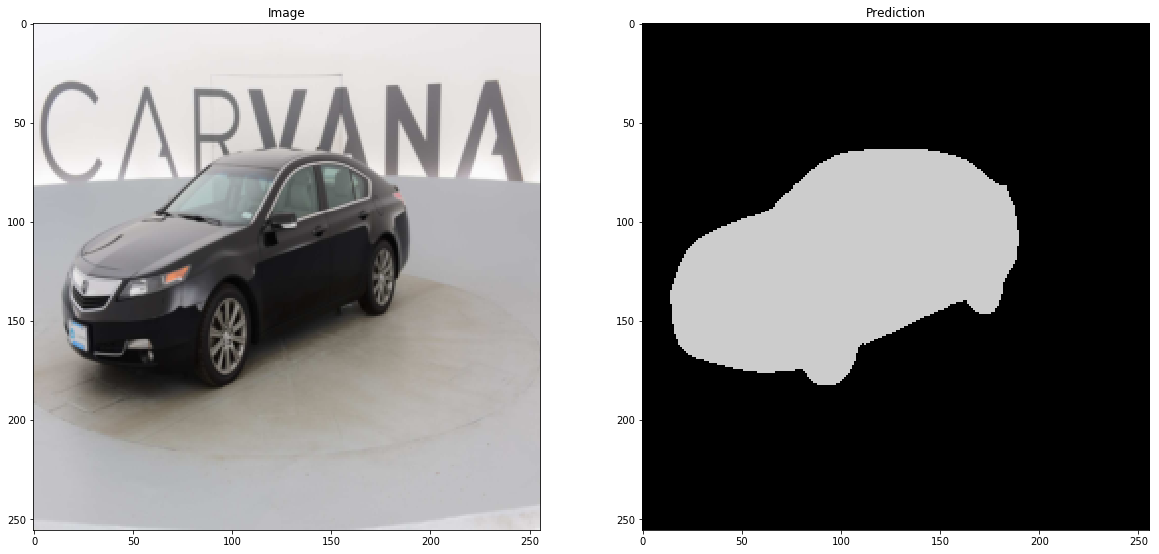

In [15]:
def test_data_preview():
    counter = 0
    model.eval()
    test_dataset = CarvanaDataset(operation='test', transform=data_transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

    for i, (inputs, labels) in enumerate(iter(test_loader)):
        fig, axes = plt.subplots(1, 2, figsize=(20,15))
        row = counter
        inputs = inputs.cuda()
        labels = labels.cuda()

        # Predict
        pred = model(inputs)
        pred = pred.data.cpu().numpy()
        pred = pred.squeeze()

        img_p = inputs.data.cpu().numpy()
        img_p = img_p.squeeze()*255
        img_p = np.moveaxis(img_p, 0, -1)

        axes[0].imshow(img_p, interpolation='nearest')
        axes[1].imshow(pred > 0.5, cmap='nipy_spectral', interpolation='nearest')

        axes[0].set_title('Image')
        axes[1].set_title('Prediction')
        counter += 1
        if counter > 2:
            break
        plt.show()
        
test_data_preview()

# U-Net Fully Convolutional Neural Network With ConvTranpose2d for Upsampling
Training a model from scratch.

In [14]:
model = FCN()

load_fcn = False

if load_fcn:
    checkpoint = torch.load('G:\\projects\\thinkful\\final\\data\\models\\FCN_0')
    model.load_state_dict(checkpoint)

if torch.cuda.is_available():
    model = model.cuda()

In [15]:
train_model = True

optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)     # After 10 epochs the learning rate will be reduced
criterion = BCEDiceLoss().cuda()

n_epochs = 30

if train_model:
    loss_hist = []
    for epoch in range(n_epochs):
        curr_loss = train(train_loader, model, epoch, n_epochs)
        save_model(model, epoch, 'FCN')
        loss_hist.append(curr_loss)


    loss_hist = np.array(loss_hist)
    # Saving loss history for graphing
    np.savez('FCN_Loss', loss_hist)
    print(f'Ending Loss - {curr_loss}')

[TRAIN] - EPOCH 30/ 30 - BATCH LOSS: 0.0106: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 5088/5088 [17:45<00:00,  4.77it/s]


Ending Loss - 0.010585388168692589


# Previewing Images - FCN

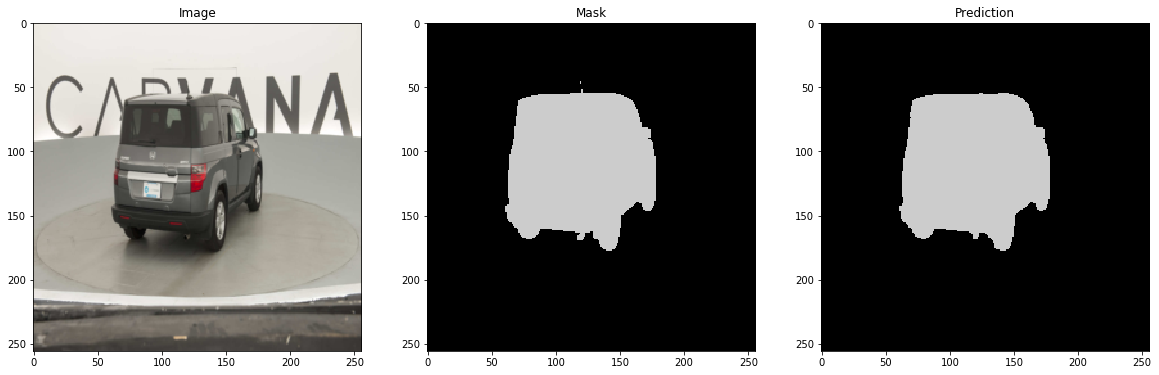

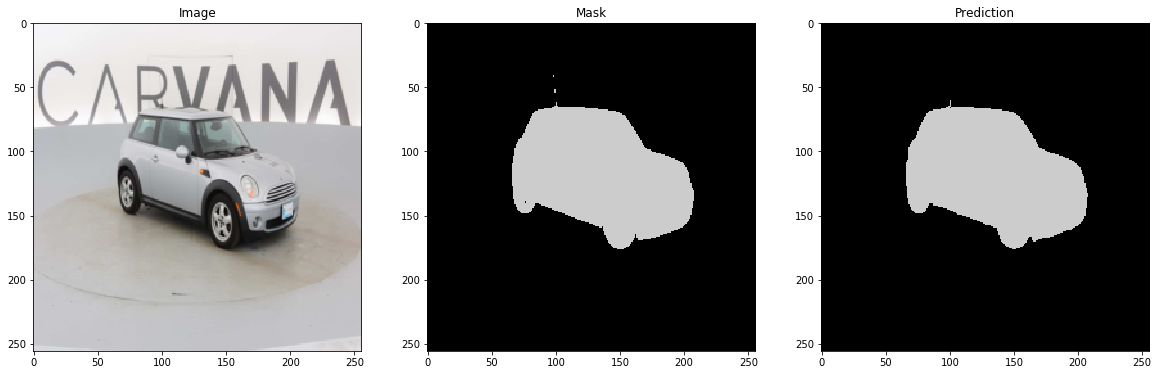

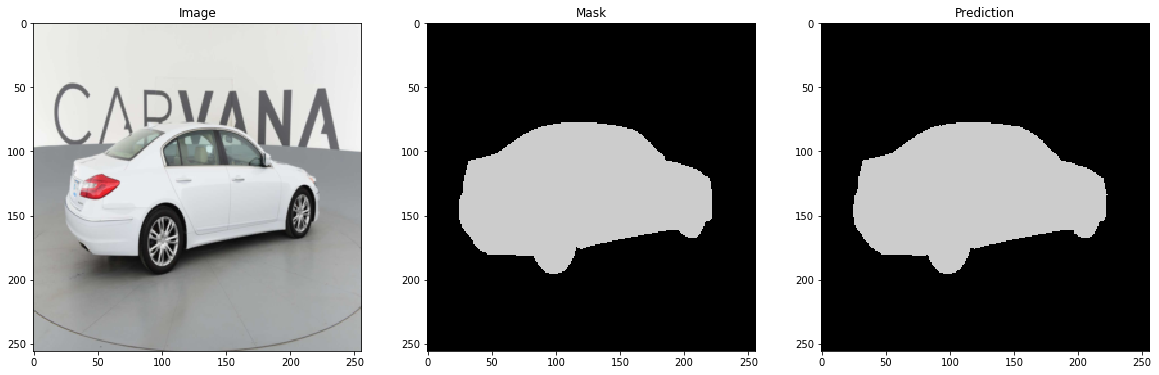

In [16]:
model_preview()

# Testing the Model - FCN

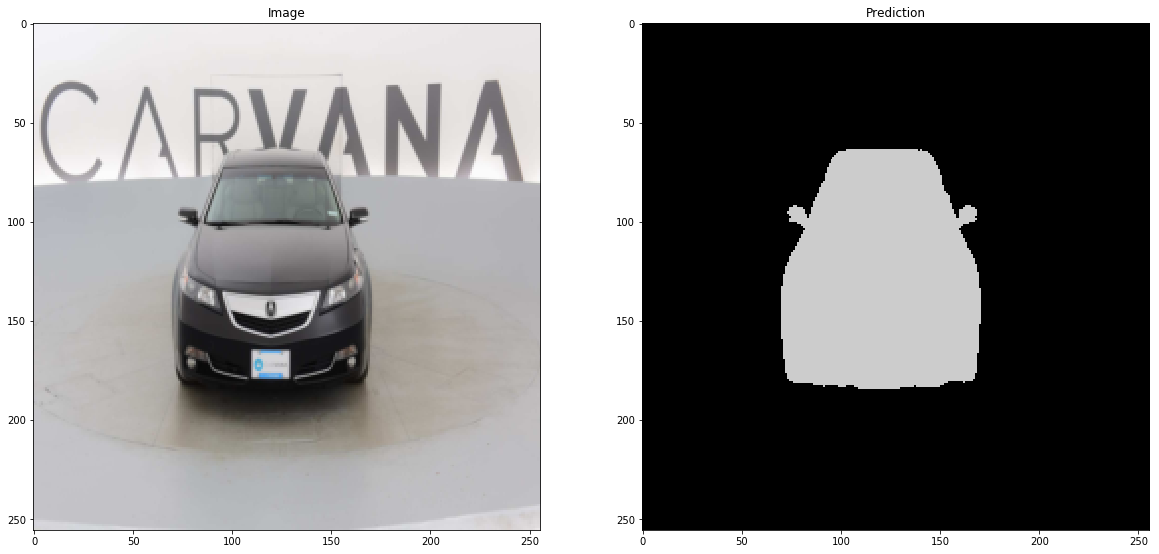

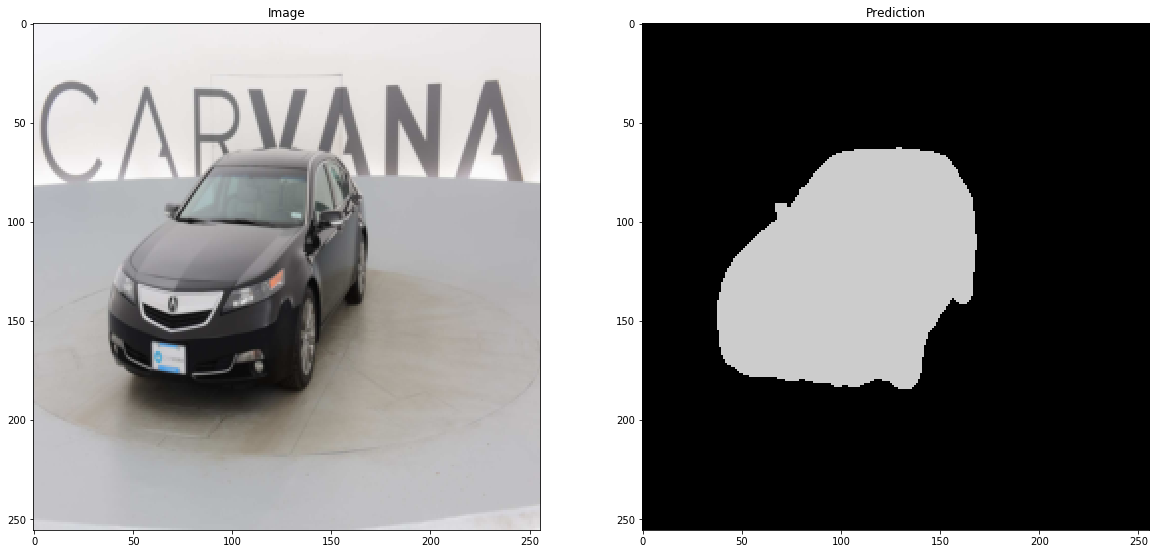

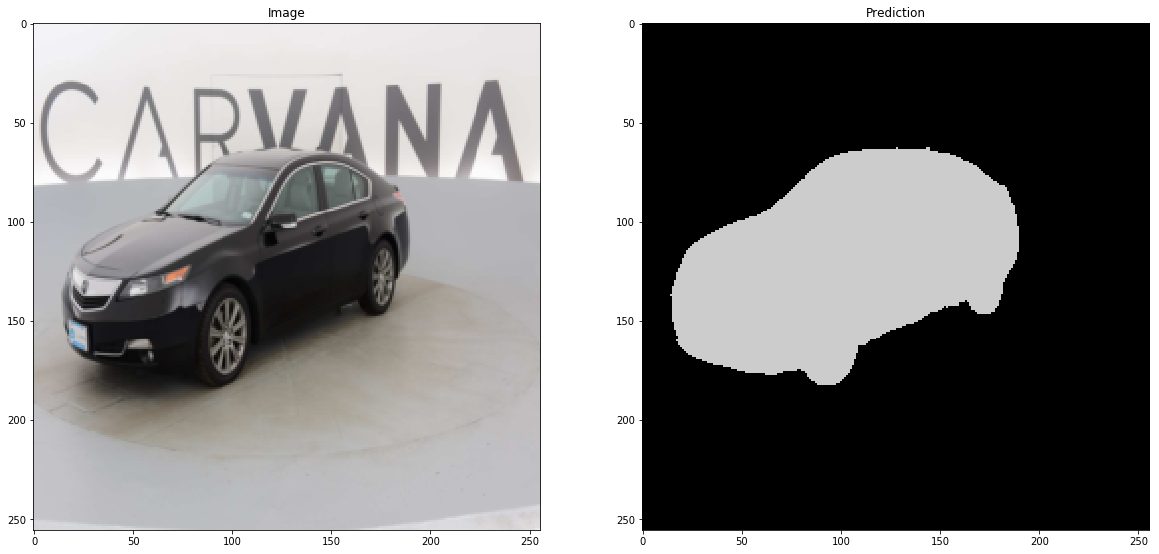

In [17]:
test_data_preview()

# Comparing Training Loss
I had made a little mistake in that I let the FCN run for 1 epoch before tracking the loss. So the FCN has been ran for 31 epochs.

In [43]:
vgg_unet_file = np.load('G:\\projects\\thinkful\\final\\VGG_UNET_loss.npz')
fcn_file = np.load('G:\\projects\\thinkful\\final\\FCN_Loss.npz')

# The loss history was saved as tensor objects and needs to be convereted
def tensor_to_float(np_file):
    hist = []
    for tensor in np_file['arr_0']:
        hist.append(tensor.cpu().numpy().item())
    return hist

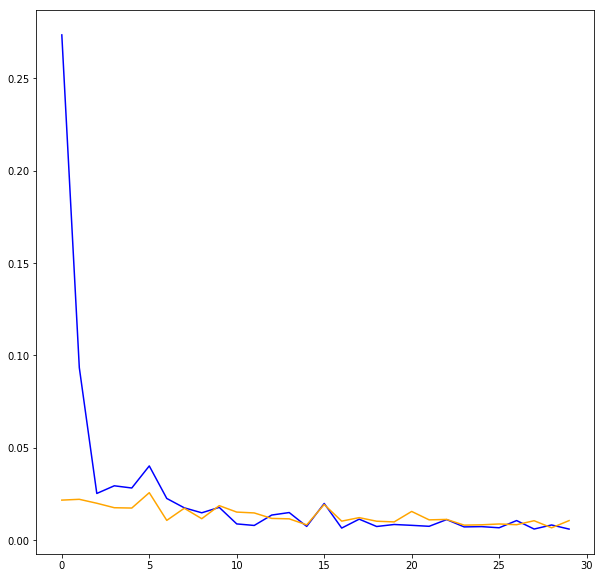

In [44]:
# Getting converted file types
vgg_unet_loss = tensor_to_float(vgg_unet_file)
fcn_loss = tensor_to_float(fcn_file)
graph_index = range(0,30)

# Graphing Loss
fig, ax1 = plt.subplots(figsize=(10,10))
sns.lineplot(x=graph_index, y=vgg_unet_loss, ax=ax1, color='b')
sns.lineplot(x=graph_index, y=fcn_loss, ax=ax1, color='orange')
plt.show()

# Conclusion

Within the first few epochs both models returned a loss of less than 0.1. This could be a sign of overfitting, but for image masking scores under 90% would likely not be usable. When comparing the models the, the transfer learning model performed slightly better in score. However when both models are faced with the test images. It's clear to see that the transfer learning model is creating more confident masks. For the test image, a black car with heavy shadows, it's apparent that the plain U-Net is struggling around the shadowed edges. Unfortunately neither model was capable of correctly masking out antennas on a consistent basis. Training with a higher resolution may yield better results in this regard.

If one of the models is overfitting my guess would be the FCN model Because the upscale process is being handled by ConvTranspose2d layers that also have trainable weights. This issue might go away with an increase in training data.

For further testing I would be interested in training with larger resolutions. Since I used such a large network I was limited to an input resolution of 256x256. A higher resolution may help the model learn finer features and result in smoother masks.